<a href="https://colab.research.google.com/github/putrinahampun/FinalProject-SKom/blob/main/EfficientNet/PretrainedModel3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LOAD DATASET

Menghubungkan google colab dengan google drive agar bisa mengakses data yang tersimpan didalam gdrive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Keterangan:
* zip_file merupakan variabel yang menyimpan path yang mengarah pada dataset yang masih berbentuk zip.
* dataset merupakan variabel yang menyimpan path yang mengarah pada folder dataset, tempat hasil ekstraksi file zip dilakukan

In [2]:
zip_file = '/content/drive/MyDrive/TA/dataset.zip'
dataset = '/content/drive/MyDrive/TA'

Melakukan ekstraksi file zip dan menyimpan kedalam folder path di variabel dataset

In [ ]:
import zipfile
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(dataset)

## PRE-PROCESSING DATA

### Segmentation Using K-Means Clustering

Mendefenisikan libraries yang dibutuhkan

In [ ]:
import cv2
import numpy as np
from google.colab import files
import os

**Penggunaan Teknik Equalization**: Menggunakan Equalization Histogram untuk meningkatkan kontras dalam gambar dengan mendistribusikan intensitas piksel secara merata.Gambar akan dikonversi terlebih dahulu kedalam bentuk HSV (Hue, Saturation, Value) agar fungsi equalizeHist dapat diterapkan. Setelahnya, format gambar akan dikembalikan kedalam bentuk BGR

In [ ]:
def equalize_rgb_image(image):
    hsi_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsi_image[:, :, 2] = cv2.equalizeHist(hsi_image[:, :, 2])
    equalized_image = cv2.cvtColor(hsi_image, cv2.COLOR_HSV2BGR)
    return equalized_image

Penggunaan teknik Unsharp Mask: mengaplikasikan efek "unsharp mask" pada gambar untuk meningkatkan kejelasan yang lebih baik dan tepi objek pada gambar yang lebih terdefinisi.

In [ ]:
def apply_unsharp_mask(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    unsharp_mask = cv2.addWeighted(image, 1.5, blurred, -0.5, 0)
    return unsharp_mask

Menerapkan K-Means Clustering untuk segmentasi konjungtiva mata pada gambar melalui saluran merah (red_channel) pada gambar.

In [ ]:
def apply_kmeans_clustering_red(image, k=2):

    red_channel = image[:, :, 2]
    red_pixels = red_channel.reshape((-1, 1))
    red_pixels = np.float32(red_pixels)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(red_pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)

    segmented_red_channel = centers[labels.flatten()]
    segmented_red_channel = segmented_red_channel.reshape(red_channel.shape)

    _, binary_mask = cv2.threshold(segmented_red_channel, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, np.ones((15, 15), np.uint8))

    return binary_mask

Mengaplikasikan operasi bitwise AND antara gambar asli (original_image) dan masker biner (binary_mask) untuk mengekstrak piksel dari gambar asli yang sesuai dengan area yang diidentifikasi oleh masker biner.

In [ ]:
def apply_convolution(original_image, binary_mask):
    conjunctiva_pixels = cv2.bitwise_and(original_image, original_image, mask=binary_mask)
    return conjunctiva_pixels

In [ ]:
def process_images(image_directory, output_directory):
    for category in os.listdir(image_directory):
        category_path = os.path.join(image_directory, category)
        if os.path.isdir(category_path):
            output_category_path = os.path.join(output_directory, category)
            os.makedirs(output_category_path, exist_ok=True)

            for file_name in os.listdir(category_path):
                if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(category_path, file_name)

                    # Read the image
                    original_image = cv2.imread(image_path)

                    # Step 1: Equalization of the image in RGB
                    equalized_image = equalize_rgb_image(original_image)

                    # Step 2: Filter Unsharp Masking
                    unsharp_mask_image = apply_unsharp_mask(equalized_image)

                    # Step 3: Red Channel Mask
                    red_channel_mask = apply_kmeans_clustering_red(unsharp_mask_image)

                    # Step 4: Convolution Original Image - Red Channel Mask
                    conjunctiva_pixels = apply_convolution(original_image, red_channel_mask)

                    # Save the segmented image
                    output_file_path = os.path.join(output_category_path, file_name)
                    cv2.imwrite(output_file_path, conjunctiva_pixels)

# Specify the directories
input_directory = '/content/drive/MyDrive/TA/original' #tempat dataset yang udah dicropping ingat!
output_directory = '/content/drive/MyDrive/TA/dataset' #arahkan ke dataset untuk splitting dll.

# Process the images and save the segmented results
process_images(input_directory, output_directory)

# Zip the output folder
!zip -r segmented_images.zip {output_directory}

# Download the zip file
files.download('dataset.zip')

### Labeling and Splitting

Menginisialisasikan libraries yang dibutuhkan

In [3]:
import os
import random
import shutil

Membagi dataset untuk data latih (training) dan data validasi (validation). Pada penelitian ini digunakan pembagian 80% data kedalam data latih dan 20% kedalam data validasi.

In [4]:
train_ratio = 0.8
validation_ratio = 0.2

Membuat folder baru didalam folder dataset, dengan folder "train" untuk menyimpan data latih dan folder "validation" untuk menyimpan data validasi.  

In [5]:
base_dir = dataset
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

Di dalam folder "train" dan "validation", masing-masing dibentuk folder untuk melabeli data yang digunakan. Penelitian bertujuan untuk mengindentifikasi data kedalam "anemia" atau "non-anemia". Maka dari itu, kelas label terdiri atas anemia dan non-anemia. Folder train dan validation, masing-masing akan berisi folder "anemia" dan "non-anemia".

In [6]:
saved_train_nonanemia = os.path.join(train_dir, 'non-anemia')
saved_validation_nonanemia = os.path.join(validation_dir,'non-anemia')
os.makedirs(saved_train_nonanemia, exist_ok=True)
os.makedirs(saved_validation_nonanemia, exist_ok=True)

saved_train_anemia = os.path.join(train_dir, 'anemia')
saved_validation_anemia = os.path.join(validation_dir,'anemia')
os.makedirs(saved_train_anemia, exist_ok=True)
os.makedirs(saved_validation_anemia, exist_ok=True)

Berikut merupakan fungsi split untuk membagi dataset kedalam data latih (train) dan data validasi (validation), serta melakukan pelabelan dengan menempatkan data kedalam folder anemia atau non-anemia.

In [7]:
def split_and_move_images(source_dir, target_train_dir, target_validation_dir, train_ratio):
    files = os.listdir(source_dir)
    random.shuffle(files)
    split_index = int(len(files) * train_ratio)
    train_files = files[:split_index]
    validation_files = files[split_index:]

    for filename in train_files:
        source_path = os.path.join(source_dir, filename) #dataset/ anemia / file1.jpg
        target_path = os.path.join(target_train_dir) # train / anemia
        shutil.copy(source_path, target_path)

    for filename in validation_files:
        source_path = os.path.join(source_dir, filename)
        target_path = os.path.join(target_validation_dir)
        shutil.copy(source_path, target_path)


Menginisialisasikan variabel anemia_dir yang menyimpan data anemia dan non_anemia_dir yang menyimpan data non-anemia

In [8]:
non_anemia_dir = '/content/drive/MyDrive/TA/dataset/non-anemia'
anemia_dir ='/content/drive/MyDrive/TA/dataset/anemia'

Melakukan pembagian data kedalam training dan validation dengan memanggil fungsi split_and_move_images

In [ ]:
# Split and move images for the 'anemia' class
split_and_move_images(anemia_dir, saved_train_anemia, saved_validation_anemia, train_ratio)

# Split and move images for the 'non-anemia' class
split_and_move_images(non_anemia_dir, saved_train_nonanemia, saved_validation_nonanemia, train_ratio)

Menginisialisasikan variabel-variabel train dan validation yang menyimpan data yang telah dibagi.

In [9]:
train_anemia = '/content/drive/MyDrive/TA/train/anemia'
validation_anemia = '/content/drive/MyDrive/TA/validation/anemia'
train_non_anemia = '/content/drive/MyDrive/TA/train/non-anemia'
validation_non_anemia = '/content/drive/MyDrive/TA/validation/non-anemia'

Menghitung jumlah file yang tersimpan pada masing-masing folder dalam train dan validation.

In [10]:
def countFiles(folder_path):
  file_count = 0
  for root, dirs, files in os.walk(folder_path):
    file_count += len(files)
  print(f'Jumlah File pada folder {folder_path} adalah: {file_count}')

Memanggil fungsi countFiles untuk mengetahui jumlah file gambaar pada masing-masing folder.

In [11]:
countFiles(train_anemia)
countFiles(validation_anemia)
countFiles(train_non_anemia)
countFiles(validation_non_anemia)

Jumlah File pada folder /content/drive/MyDrive/TA/train/anemia adalah: 160
Jumlah File pada folder /content/drive/MyDrive/TA/validation/anemia adalah: 40
Jumlah File pada folder /content/drive/MyDrive/TA/train/non-anemia adalah: 160
Jumlah File pada folder /content/drive/MyDrive/TA/validation/non-anemia adalah: 40


## MODELING

Memastikan agar akurasi model tidak berubah-ubah setelah run ulang

In [73]:
import numpy as np
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

### Callbacks

Mendefenisikan modul yang dibutuhkan

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

Mendefinisikan tempat penyimpanan model checkpoints

In [14]:
checkpoint_dir = os.path.join(dataset,'checkpoints')
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_filename = "model_checkpoint_epoch_{epoch:02d}.h5"
checkpoint_filepath = os.path.join(checkpoint_dir, checkpoint_filename)

Mendefinisikan fungsi callbak model checkpoint

In [15]:
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

Mendefinisikan earlystopping callback

In [16]:
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    mode='min',
    verbose=1
)

Mendefinisikan ReduceLROnPlateau

In [17]:
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    mode='min',
    verbose=1
)

### Menggunakan Arsitektur CNN

Mendefinisikan libraries yang dibutuhkan, dalam penelitian ini digunakan library tensorflow. Dari library tensorflow, diambil modul RMSprop sebagai optimizer. Kemudian terdapat modul ImageDataGenerator untuk proses augmentasi

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Melakukan proses augmentasi data train dan validasi. Pada penelitian ini digunakan batch_size = 10.

In [ ]:
train_datagen = ImageDataGenerator(  rescale= 1./255,
                                     horizontal_flip = True,
                                     brightness_range=[0.8, 1.8] )

validation_datagen = ImageDataGenerator( rescale= 1./255 )

train_generator = train_datagen.flow_from_directory(  train_dir,
                                                      target_size=(300, 300),
                                                      batch_size= 10,
                                                      class_mode='binary' )

validation_generator = validation_datagen.flow_from_directory(   validation_dir,
                                                                 target_size=(300, 300),
                                                                 batch_size= 10,
                                                                 class_mode='binary' )

Found 320 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import numpy as np

# Example image
img_path = 'non-anemia (2).jpg'
img = image.load_img(img_path, target_size=(300, 300))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Initialize ImageDataGenerator with brightness_range and contrast_stretching
datagen = ImageDataGenerator(
    brightness_range=[0.8, 1.8]
)

# Generate augmented images
augmented_images = datagen.flow(img_array, batch_size=1)

# Plot augmented images
plt.figure(figsize=(8, 4))
for i in range(3):
    augmented_img = augmented_images.next()[0]
    plt.subplot(2, 3, i + 1)
    plt.imshow(augmented_img.astype('uint8'))
    plt.axis('off')

plt.show()


In [ ]:
def augment_and_generate(generator, augmentation_factor):
    while True:
        # Generate a batch of data
        x_batch, y_batch = next(generator)

        # Augment the data augmentation_factor times
        augmented_data = [generator.random_transform(image) for image in x_batch]

        # Concatenate the original batch with the augmented batches
        x_augmented = np.concatenate([x_batch] + augmented_data)
        y_augmented = np.concatenate([y_batch] * (augmentation_factor + 1))

        yield x_augmented, y_augmented

# Konfigurasi generator dengan augmentation_factor=6
augmentation_factor = 3
train_generator_augmented = augment_and_generate(train_generator, augmentation_factor)

Membentuk fungsi create_model() yang menyimpan layer-layer conv dan maxpool, yang akan digunakan untuk mengekstrak fitur-fitur dari gambar yang telah berhasil disegmentasi. Pada penelitian ini digunakan ukuran gambar 300 x 300 pixels.

In [ ]:
def create_model():

  model = tf.keras.models.Sequential([

      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(300,300,3)),
      tf.keras.layers.MaxPooling2D(2, 2),

      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),

      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),

      tf.keras.layers.Conv2D(256, (3,3), activation='relu'), #penambahan layer
      tf.keras.layers.MaxPooling2D(2,2),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation='relu'), #penambahan layer
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile( loss='binary_crossentropy',
                 optimizer=Adam(learning_rate=1e-3),
                 metrics=['accuracy'])

  return model

Melakukan proses training dengan mendefinisikan epoch (perulangan pelatihan model) sebanyak 20. Menggunakan model.fit() untuk memperoleh hasil akurasi training dan validasi data.

In [ ]:
epochs = 25
model = create_model()

history = model.fit( train_generator,
                     steps_per_epoch= 32,
                     epochs= epochs,
                     validation_data= validation_generator,
                     validation_steps= 8,
                     callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback])

Epoch 1/25
32/32 [==============================] - ETA: 0s - loss: 0.5384 - accuracy: 0.7031
Epoch 1: val_loss did not improve from 0.02299
32/32 [==============================] - 6s 131ms/step - loss: 0.5384 - accuracy: 0.7031 - val_loss: 0.1596 - val_accuracy: 0.9875 - lr: 0.0010
Epoch 2/25
32/32 [==============================] - ETA: 0s - loss: 0.2008 - accuracy: 0.9406
Epoch 2: val_loss did not improve from 0.02299
32/32 [==============================] - 4s 130ms/step - loss: 0.2008 - accuracy: 0.9406 - val_loss: 0.1037 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 3/25
32/32 [==============================] - ETA: 0s - loss: 0.1618 - accuracy: 0.9531
Epoch 3: val_loss did not improve from 0.02299
32/32 [==============================] - 3s 98ms/step - loss: 0.1618 - accuracy: 0.9531 - val_loss: 0.0713 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 4/25
32/32 [==============================] - ETA: 0s - loss: 0.0974 - accuracy: 0.9656
Epoch 4: val_loss did not improve from 0.02299
32/32

Mendefinisikan fungsi untuk menampilkan grafik akurasi training dan validation.

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_acc(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training accuracy')
  plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training Loss')
  plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

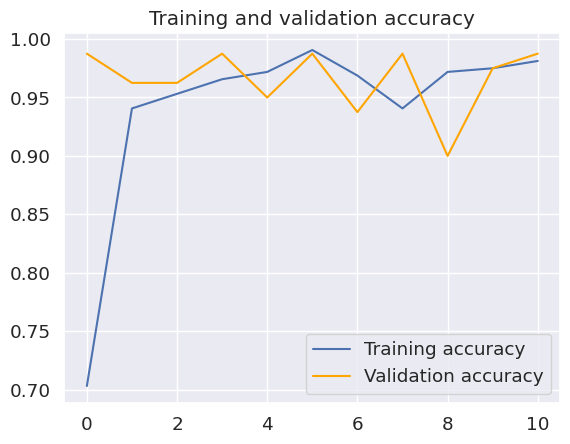

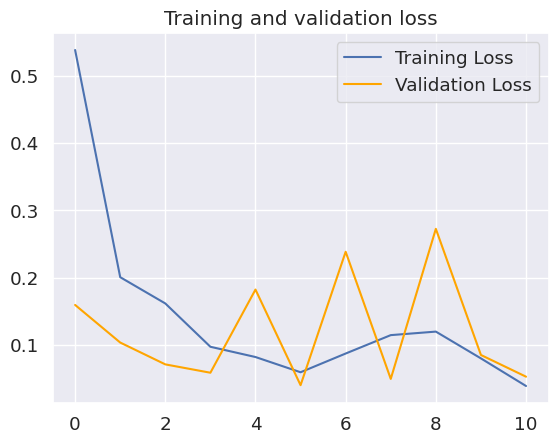

In [ ]:
plot_loss_acc(history)

### Menggunakan Pre-trained Model: EfficientNet

In [74]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import layers
from tensorflow.keras import Model

In [76]:
train_datagen = ImageDataGenerator(  rescale= 1./255,
                                     horizontal_flip = True,
                                     brightness_range=[0.8, 1.8] )

validation_datagen = ImageDataGenerator( rescale= 1./255 )

train_generator = train_datagen.flow_from_directory(  train_dir,
                                                      target_size=(300, 300),
                                                      batch_size= 10,
                                                      class_mode='binary' )

validation_generator = validation_datagen.flow_from_directory(   validation_dir,
                                                                 target_size=(300, 300),
                                                                 batch_size= 10,
                                                                 class_mode='binary' )

Found 320 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


In [77]:
def augment_and_generate(generator, augmentation_factor):
    while True:
        # Generate a batch of data
        x_batch, y_batch = next(generator)

        # Augment the data augmentation_factor times
        augmented_data = [generator.random_transform(image) for image in x_batch]

        # Concatenate the original batch with the augmented batches
        x_augmented = np.concatenate([x_batch] + augmented_data)
        y_augmented = np.concatenate([y_batch] * (augmentation_factor + 1))

        yield x_augmented, y_augmented

# Konfigurasi generator dengan augmentation_factor=6
augmentation_factor = 6
train_generator_augmented = augment_and_generate(train_generator, augmentation_factor)

In [78]:
pre_trained_model = EfficientNetB3(weights='imagenet', include_top=False, drop_connect_rate=0.2)

pre_trained_model.trainable = False
# for layer in pre_trained_model.layers[-10:]:
#   if not isinstance(layer, layers.BatchNormalization):
#     layer.trainable = True

In [ ]:
pre_trained_model.summary()

In [79]:
top_dropout_rate = 0.2

x = layers.GlobalAveragePooling2D(name="avg_pool")(pre_trained_model.output)
x = layers.BatchNormalization()(x)
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
output = layers.Dense(1,activation="sigmoid",name="pred")(x)

In [80]:
model = Model(pre_trained_model.input, output)

In [ ]:
model.summary()

In [81]:
model.compile(  optimizer = Adam(learning_rate = 1e-4 ),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'] )

In [82]:
epochs = 32

history = model.fit( train_generator,
                     steps_per_epoch= 32,
                     epochs= epochs,
                     validation_data= validation_generator,
                     validation_steps= 8,
                     callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback])

Epoch 1/32
32/32 [==============================] - ETA: 0s - loss: 0.8436 - accuracy: 0.4719
Epoch 1: val_loss did not improve from 0.67526
32/32 [==============================] - 19s 213ms/step - loss: 0.8436 - accuracy: 0.4719 - val_loss: 0.7121 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/32
32/32 [==============================] - ETA: 0s - loss: 0.8255 - accuracy: 0.4219
Epoch 2: val_loss did not improve from 0.67526
32/32 [==============================] - 3s 106ms/step - loss: 0.8255 - accuracy: 0.4219 - val_loss: 0.6969 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/32
32/32 [==============================] - ETA: 0s - loss: 0.7764 - accuracy: 0.4563
Epoch 3: val_loss did not improve from 0.67526
32/32 [==============================] - 3s 105ms/step - loss: 0.7764 - accuracy: 0.4563 - val_loss: 0.6953 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/32
32/32 [==============================] - ETA: 0s - loss: 0.7254 - accuracy: 0.4969
Epoch 4: val_loss did not improve from

In [83]:
import matplotlib.pyplot as plt

def plot_loss_acc(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training accuracy')
  plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training Loss')
  plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

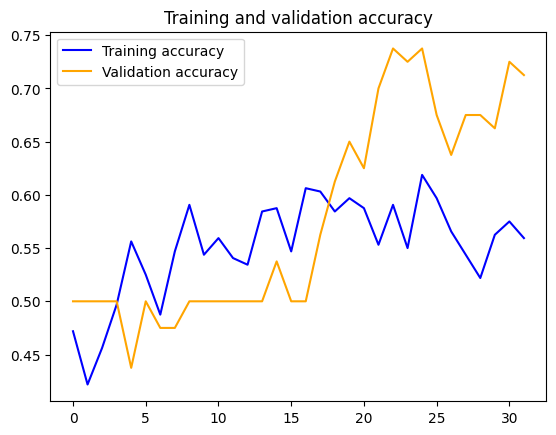

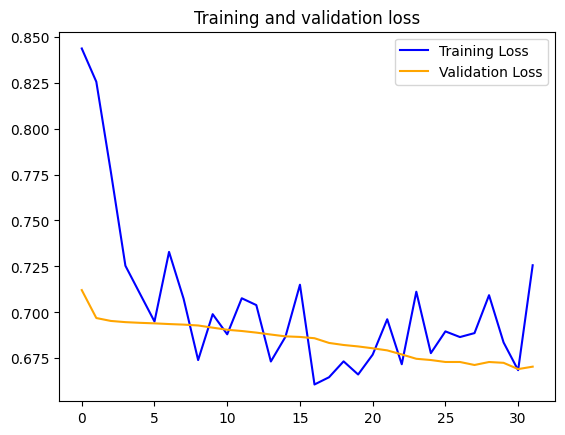

In [84]:
plot_loss_acc(history)

### Testing

In [86]:
# Assuming your testing dataset is in a directory called 'test_dir'
test_dir = '/content/drive/MyDrive/TA/testing2'

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(300, 300),
    batch_size=10,
    class_mode='binary')

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test accuracy: {test_accuracy}')
print(f'Test loss: {test_loss}')


Found 40 images belonging to 2 classes.
4/4 [==============================] - 0s 86ms/step - loss: 0.7157 - accuracy: 0.4500
Test accuracy: 0.44999998807907104
Test loss: 0.7157458066940308


Berikut adalah kode apabila ingin melakukan testing dengan model yang telah disimpan dalam format h5

In [57]:
from tensorflow.keras.models import load_model

test_dir = '/content/drive/MyDrive/TA/testing2'

# Path ke file model .h5 yang telah disimpan
saved_model_path = '/content/drive/MyDrive/TA/checkpoints/Model2-CNN/model_checkpoint_epoch_04.h5'

# Memuat model dari file .h5
loaded_model = load_model(saved_model_path)

# Menggunakan ImageDataGenerator untuk mengonversi gambar dari direktori testing
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(300, 300),
    batch_size=10,
    class_mode='binary')

# Evaluasi model yang telah dimuat pada dataset pengujian
test_loss, test_accuracy = loaded_model.evaluate(test_generator)

print(f'Test accuracy: {test_accuracy}')
print(f'Test loss: {test_loss}')


Found 40 images belonging to 2 classes.
4/4 [==============================] - 1s 25ms/step - loss: 0.5147 - accuracy: 0.8500
Test accuracy: 0.8500000238418579
Test loss: 0.5147241353988647


In [ ]:
import numpy as np

# Assuming your testing dataset is in a directory called 'test_dir'
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(300, 300),
    batch_size=10,
    class_mode='binary',
    shuffle=False)

# Get predictions for the test dataset
predictions = model.predict(test_generator)

# Convert predicted probabilities to class labels (0 or 1)
predicted_labels = np.round(predictions)

# Get true labels from the generator
true_labels = test_generator.classes

# Get the mapping from class indices to class names
class_names = list(test_generator.class_indices.keys())

# Convert numeric labels to class names for true labels
true_class_names = [class_names[label] for label in true_labels]

# Convert numeric labels to class names for predicted labels
predicted_class_names = [class_names[int(label)] for label in predicted_labels]

# Now you can use true_class_names and predicted_class_names for analysis or printing
for i in range(len(true_class_names)):
    print(f"Actual: {true_class_names[i]}, Predicted: {predicted_class_names[i]}")


Found 40 images belonging to 2 classes.
4/4 [==============================] - 7s 1s/step
Actual: anemia, Predicted: non-anemia
Actual: anemia, Predicted: non-anemia
Actual: anemia, Predicted: non-anemia
Actual: anemia, Predicted: non-anemia
Actual: anemia, Predicted: non-anemia
Actual: anemia, Predicted: non-anemia
Actual: anemia, Predicted: non-anemia
Actual: anemia, Predicted: non-anemia
Actual: anemia, Predicted: non-anemia
Actual: anemia, Predicted: non-anemia
Actual: anemia, Predicted: non-anemia
Actual: anemia, Predicted: non-anemia
Actual: anemia, Predicted: non-anemia
Actual: anemia, Predicted: non-anemia
Actual: anemia, Predicted: non-anemia
Actual: anemia, Predicted: non-anemia
Actual: anemia, Predicted: non-anemia
Actual: anemia, Predicted: non-anemia
Actual: anemia, Predicted: non-anemia
Actual: anemia, Predicted: non-anemia
Actual: non-anemia, Predicted: non-anemia
Actual: non-anemia, Predicted: non-anemia
Actual: non-anemia, Predicted: non-anemia
Actual: non-anemia, Pred

In [ ]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix

# Assuming true_labels and predicted_labels are your true and predicted labels
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)

# You can also compute a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(f'Precision: {precision}')
print(f'Recall: {recall}')


Precision: 0.5
Recall: 1.0


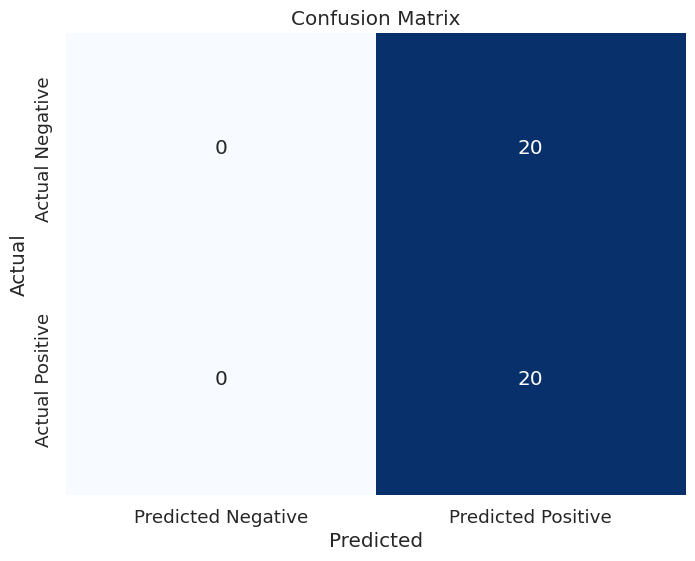

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Assuming true_labels and predicted_labels are your true and predicted labels
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Create a seaborn heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size for better readability
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### Trial and Error

In [ ]:
import numpy as np

from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded=files.upload()

for fn in uploaded.keys():

  # predicting images
  path='/content/' + fn
  img=load_img(path, target_size=(300, 300))

  x=img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=20)

  print(classes)

  if classes[0] < 0.5:
    print(fn + " is a anemia")
  else:
    print(fn + " is a non-anemia")

Saving anemia (7).jpg to anemia (7).jpg
1/1 [==============================] - 0s 114ms/step
[[0.0001464]]
anemia (7).jpg is a anemia


In [ ]:
# Assuming train_generator is your training data generator
class_indices = train_generator.class_indices
class_labels = list(class_indices.keys())

print("Class Indices:", class_indices)
print("Class Labels:", class_labels)


Class Indices: {'anemia': 0, 'non-anemia': 1}
Class Labels: ['anemia', 'non-anemia']
